In [44]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(stringr))
library(plyr)

library(purrr)
library(rstatix)
library(ggpubr)
library(ggsci)
library(ggrepel)
source('/home//jupyter/BRI_Figures/helper_function/helper_function_IHA.r')

In [45]:

is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  } else {return('black')}
}

In [46]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_annotation$label<-gsub(' cell','',color_annotation$label)
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [47]:
df=read.csv('03_DEGs_and_EnrichmentAnalysis/IGHG1_IGHG2_CoreB.csv')

In [48]:
df<-df %>% filter(Gene=='IGHG1')

In [49]:
df <- df %>% dplyr::mutate(`Age Group` = case_when(
  cohort.cohortGuid == "BR1" ~ "Young",
  cohort.cohortGuid == "BR2" ~ "Older",
  TRUE ~ NA_character_
))
df$`Age Group`<-factor(df$`Age Group`,levels=c("Young","Older"))

In [50]:
df$Group<-paste0(df$`Age Group`,'_',df$Flu_Day)

In [51]:
df$celltype<-"Core memory B"

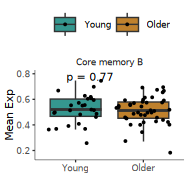

In [52]:
options(repr.plot.width = 40/25.4, repr.plot.height = 40/25.4)


p<-ggplot(df, aes(x=`Age Group`, y=Mean_Expression, fill=`Age Group`)) +
   geom_boxplot(outlier.shape = NA,lwd=0.3) +
geom_jitter(color="black", size=0.8,stroke=0) +
theme_classic(base_size=6)+  
stat_compare_means( label = "p.format",method='wilcox.test',size=2.2) +
    scale_fill_manual(values = c("Older" = '#bf812d', "Young" = '#35978f'))+
    scale_y_continuous(limits = c(NA, NA),
                       expand = expansion(mult = c(0.1, 0.15)))+
theme(legend.position="none")+
xlab('')+
ylab('Mean Exp')+
facet_wrap(~celltype,  ncol=1, scale='free_y') +theme(
panel.border = element_blank())   +
    theme(axis.line = element_line(colour = "black", linewidth = 0.1),
          legend.position = "top",
          legend.title = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          strip.background = element_rect(linewidth = 0),
          axis.title.x = element_text(margin = margin(t = 1)))
p




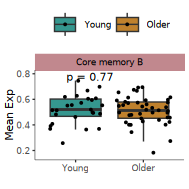

In [53]:
plot <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', plot$layout$name))
strip_labels <- sapply(strips, function(i) {
  plot$grobs[[i]]$grobs[[1]]$children[[2]]$children[[1]]$label
})
strip_labels<-gsub(' cell','',strip_labels)

pal <- color_vector[strip_labels]
text_color <- sapply(color_vector[strip_labels], is_dark_color)

strip_names <- plot$layout$name[strips]


for (i in seq_along(strips)) {
  strip_name <- strip_names[i]

  
  k <- which(grepl('rect', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', plot$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  
  adjusted_color <- adjustcolor(pal[i], alpha.f = 0.8)
  
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <- adjusted_color
  plot$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(plot)
ggsave('FigureG.pdf',plot,width = 40/25.4,height = 40/25.4)